In [487]:
import zarr
from buffer.frame_buffer import ReplayBuffer
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import numpy as np
import math

def rotate_origin_only(x, y, radians):
    """Only rotate a point around the origin (0, 0)."""
    xx = x * math.cos(radians) + y * math.sin(radians)
    yy = -x * math.sin(radians) + y * math.cos(radians)

    return xx, yy

In [488]:
replay_buffer = ReplayBuffer(int(2e3), history_size=1, dshape=(160, 384, 3), dtype=torch.uint8, goal_size=3)
replay_buffer.load(Path('/Users/nimit/Documents/robomaster/habitat/160x384'))
# zarr.load('/Users/nimit/Documents/robomaster/habitat/160x384', mode='r')

[!] loaded buffer


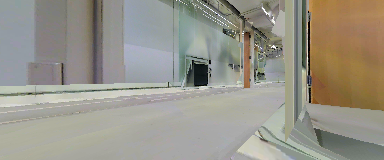

In [489]:
i = 95
Image.fromarray(replay_buffer.targets[i].squeeze().numpy())

/Users/nimit/anaconda3/envs/robot/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


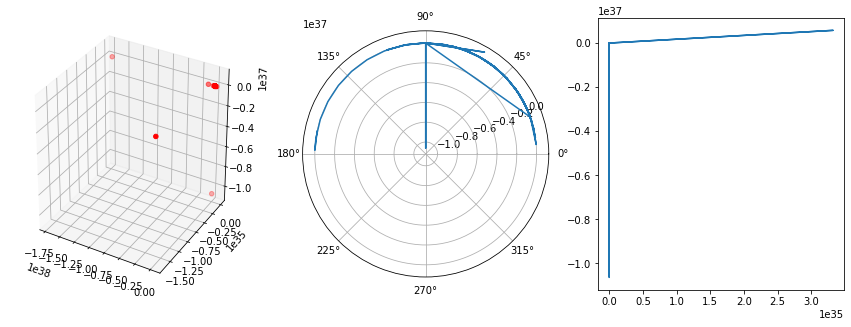

In [490]:
# 0 -> 140
# 140 -> 269
# 269 -> 431
r, c, s = replay_buffer.goals.T

fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(c, s, r, c='r', marker='o')

ax2 = fig.add_subplot(132, projection='polar')
t = np.arccos(c)
ax2.plot(t, r)

ax3 = fig.add_subplot(133)
ax3.plot(r*np.cos(t), r*np.sin(t))

In [670]:
def get_arc(actions, i, j):
    movement = actions[i:i+50] == 1
    k = np.searchsorted(np.cumsum(movement), j).item()

    R = r[i:i+k][movement[:k]]-r[i] # relative
    # R = abs(R / R.abs().mean())
    T = t[i:i+k][movement[:k]]-t[i+1] # absolute
    x, y = rotate_origin_only(R*np.cos(T), R*np.sin(T), np.pi/2)
    if T.shape[0] > 1 and (y < 0).sum() == 0: # if behind camera, then use prev
        _t = np.linspace(T[0], T[-1], 10)
        _r = np.linspace(R[0], R[-1], 10)
        _x, _y = rotate_origin_only(_r*np.cos(_t), _r*np.sin(_t), np.pi/2)
        return _x, _y

    return None
    
def world_to_cam(x, y):
    f = 384 / (2 * np.tan(120 * np.pi / 360))
    A = torch.tensor([[f,   0.0000, 192.0000], [  0.0000, f,  0.0000], [  0.0000,   0.0000,   1.0000]])
    M = torch.FloatTensor(np.stack([x, y, np.ones(y.shape[0])]))
    u, v = torch.mm(A, M)[:2]
    return u, v

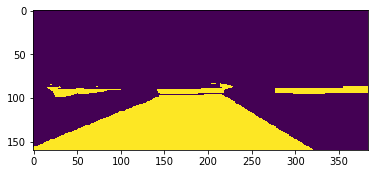

In [672]:
plt.imshow(semantic)

In [673]:
semantic.shape

(160, 384)

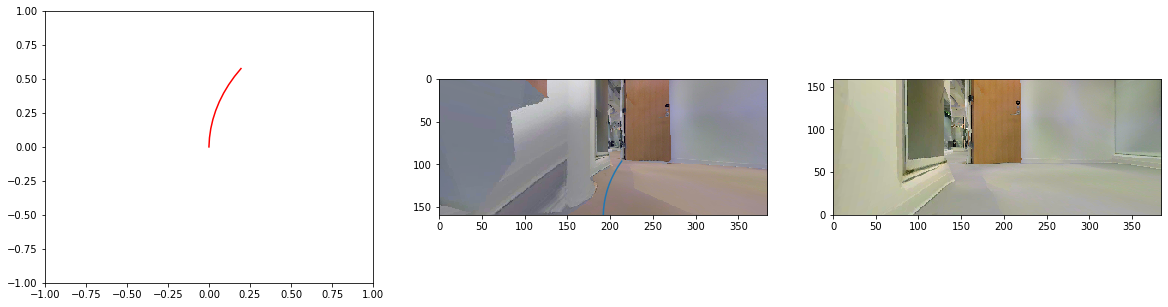

In [718]:
i, j = 14, 15

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(20,5)); ax[0].set_ylim(-1,1); ax[0].set_xlim(-1,1)
semantic = np.load(Path(f'/Users/nimit/Documents/robomaster/habitat/160x384/semantic/{i+1:03}.npy'))==2

while True:
    arc = get_arc(replay_buffer.actions, i, j) # look up to `i` frames ahead, get `j` movements
    if arc is None:
        break
    x, y = arc
    u, v = world_to_cam(x, y)
    v = 160-torch.clamp(v, min=0, max=159)
    u = torch.clamp(u, min=0, max=383)

    if semantic[int(v[-1])][int(u[-1])]:
        break
    j -=1

ax[0].plot(x, y, c='r')

ax[1].imshow(replay_buffer.targets[i].squeeze().numpy(), origin='lower')
ax[1].plot(u, v)
ax[1].imshow(semantic, alpha=0.15, cmap='jet', interpolation='none')

ax[2].imshow(replay_buffer.targets[i+j].squeeze().numpy()[::-1], origin='lower')

torch.Size([1, 160, 384, 3])

In [ ]:
import sys
sys.path.append('/Users/nimit/Documents/robomaster')
from dji_project.carla_experiments.highway_dataset import ConverterTorch

converter = ConverterTorch(h=160, w=384, fov=120,
                           hack=5, cam_height=.25, pixels_per_world=5)